In [8]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

In [9]:
DATA = 'figer'
FAMILY = {
  'bbn' : [
          'CONTACT_INFO',
          'EVENT',
          'FACILITY',
          'GPE',
          'LOCATION',
          'ORGANIZATION',
          'PRODUCT',
          'SUBSTANCE',
          'WORK_OF_ART'],
  'figer' : ['art',
            'broadcast',
            'building',
            'computer',
            'education',
            'event',
            'finance',
            'geography',
            'government',
            'internet',
            'living_thing',
            'location',
            'medicine',
            'metropolitan_transit',
            'organization',
            'people',
            'person',
            'product',
            'rail',
            'religion',
            'transportation',
            'visual_art'],
  'ontonotes_shimaoka': [
          'location/geography',
          'location/structure',
          'location/transit',
          'organization/company',
          'other/art',
          'other/event',
          'other/health',
          'other/language',
          'other/living_thing',
          'other/product',
          'person/artist'
  ]
}

SUBSET = [10, 20, 40]
KB_MODE = ['bottom_up', 'top_down', 'hybrid']
if DATA != 'ontonotes_shimaoka':
  KB_MODE.append('horizontal')
METRIC = ['precision', 'recall', 'f1']
PROJECTOR = ['classifier', 
            'kenn_bottom_up', 'kenn_top_down', 'kenn_hybrid', 
            'kenn_horizontal',
            'box', 
            'no_init_kenn_bottom_up', 'no_init_kenn_top_down', 'no_init_kenn_hybrid',            
            ]

# set paths
METRICS_FILE_PATH = f'../incremental/results/wandb_export/{DATA}/metrics_aggregated.csv'
# METRICS_FILE_PATH = f'../incremental/results/wandb_export/{DATA}/metrics.csv'
# METRICS_FILE_PATH = './metrics.csv'
FIGURES_PATH = f'./figures/{DATA}'
TITLE = {
  'bbn' : 'BBN',
  'figer' : 'FIGER',
  'ontonotes_shimaoka' : 'OntoNotes'
}

In [10]:
def filter_df(df, row_filter={}, stat=None):
  df_filtered = df.copy()
  for key, value in row_filter.items():
    if type(value) == list:
      df_filtered = df_filtered[df_filtered[key].isin(value)]
    else:
      df_filtered = df_filtered[df_filtered[key] == value]
  
  if stat:
    cols_filtered = ['projector', 'metric', 'subset', 'family'] + [c for c in df_filtered.columns if c.endswith(f'/{stat}')]
    df_filtered = df_filtered[cols_filtered]
  return df_filtered

def plot_df(df, labels = False):
    fig = sns.relplot(df,
                    x = 'delta_precision/mean',
                    y = 'delta_recall/mean', 
                    col='kb',
                    hue='projector',
                    style='subset',
                    kind='scatter')



    plt.xlim((-1, 1))
    plt.ylim((-1, 1))

    for ax in fig.axes[0]:
        ax.axhline(0, c='k')
        ax.axvline(0, c='k')
        if labels:
            title = ax.get_title().split(' ')[-1]
            for i, row in df[df['kb'] == title].iterrows():
                ax.annotate(text=row['family'], xy=(row['delta_precision/mean'], row['delta_recall/mean']))
    
    sns.move_legend(fig, 'upper right', bbox_to_anchor=(0, 1))

    plt.show()
    return fig

def compute_delta_df(df):
    delta_dfs = []

    for family in FAMILY[DATA]:
        for subset in SUBSET:
            tmp_df_filtered = filter_df(df, 
                                        {'family' : family,
                                            'subset': subset}
                                        )
            
            for metric in METRIC:
                classifier_metric = tmp_df_filtered[tmp_df_filtered['projector'] == 'classifier'][f'{metric}/mean'].values[0]
            
                tmp_df_filtered[f'delta_{metric}/mean'] = tmp_df_filtered[f'{metric}/mean'].apply(lambda x : x - classifier_metric)

            delta_dfs.append(tmp_df_filtered)

    delta_df = pd.concat(delta_dfs)

    return delta_df

In [11]:
df_metrics = pd.read_csv(METRICS_FILE_PATH)
df_metrics['projector'] =df_metrics['projector'].apply(lambda x: x.replace('_adapter_bert_ms', ''))
df_metrics.fillna(0, inplace=True)
df_metrics

,metric,projector,family,subset,precision/mean,recall/mean,f1/mean,precision/std,recall/std,f1/std
0,test/micro,box,art,10,0.900634,0.879524,0.889948,0.003398,0.002022,0.000649
1,test_incremental/macro_types,box,art,10,0.657590,0.787449,0.706201,0.093156,0.121547,0.007710
2,test_incremental_art-film/macro_types,box,art,10,0.604069,0.754386,0.625900,0.186312,0.243095,0.026981
3,test_incremental_only/macro_example,box,art,10,0.009974,0.009974,0.009974,0.003214,0.003214,0.003214
4,test_incremental/micro,box,art,10,0.636610,0.787879,0.693503,0.095828,0.119969,0.009131
...,...,...,...,...,...,...,...,...,...,...
9493,test_pretraining/macro_types,kenn_top_down,visual_art,40,0.903426,0.863643,0.883084,0.002546,0.001155,0.000674
9494,test_incremental/macro_example_exclusive,kenn_top_down,visual_art,40,0.966667,0.933333,0.949573,0.057735,0.028867,0.042931
9495,test_pretraining/micro,kenn_top_down,visual_art,40,0.913296,0.899342,0.906265,0.000993,0.000380,0.000323
9496,test_incremental_only/macro_types,kenn_top_down,visual_art,40,0.861111,0.966667,0.904534,0.127294,0.057735,0.045285


In [12]:
df_metrics_macro_example = filter_df(df_metrics, row_filter={'metric' : 'test_incremental_only/macro_example_exclusive'}, stat = 'mean')
df_metrics_macro_types = filter_df(df_metrics, row_filter={'metric' : 'test_incremental_only/macro_types'}, stat = 'mean')


## Macro example

######### SUBSET 10 ##########


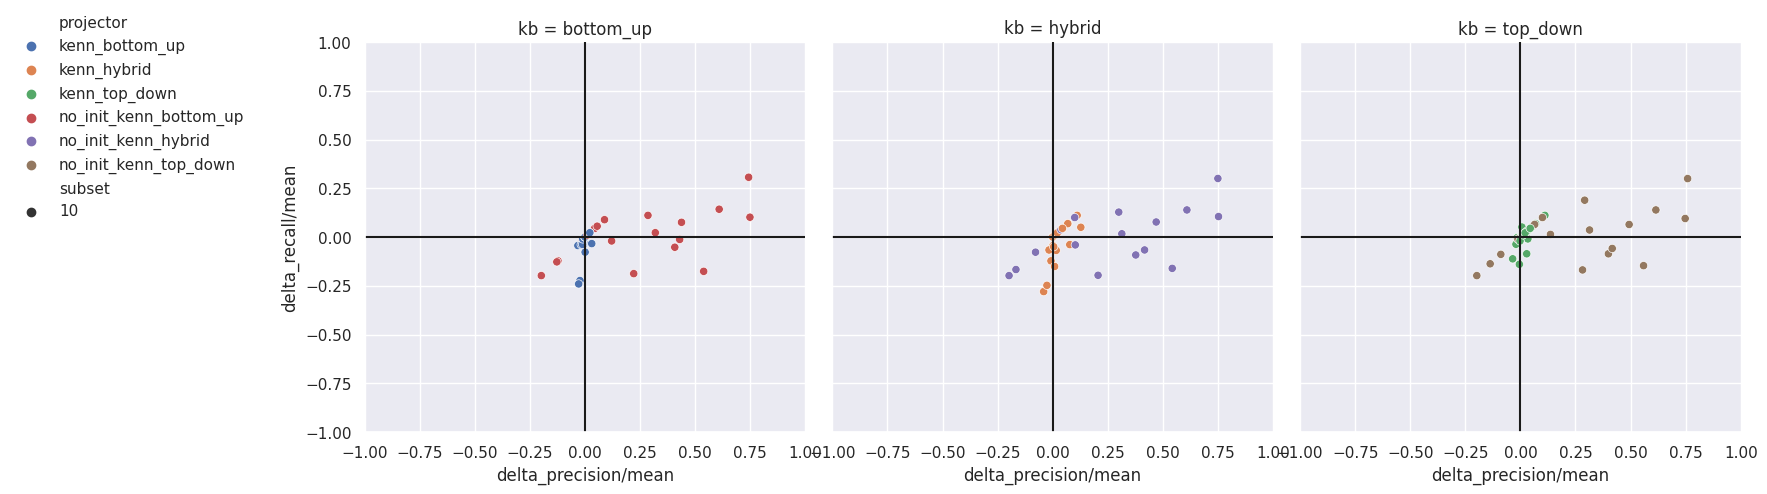

######### SUBSET 20 ##########


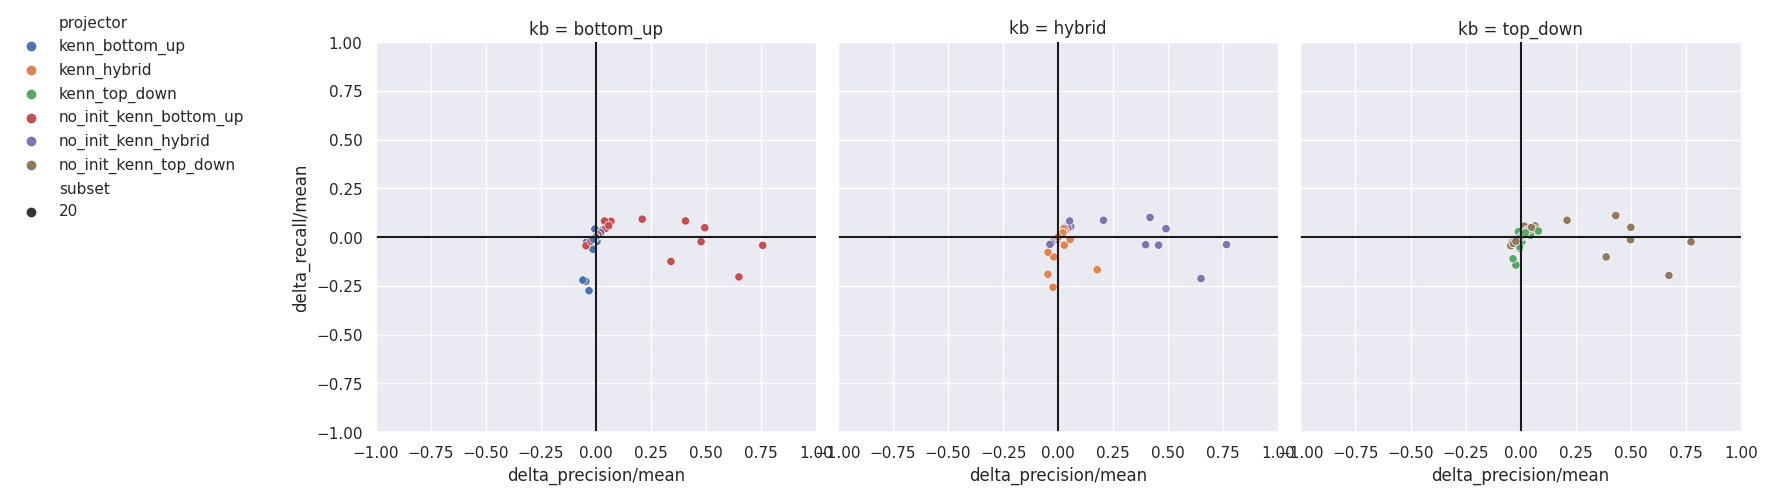

######### SUBSET 40 ##########


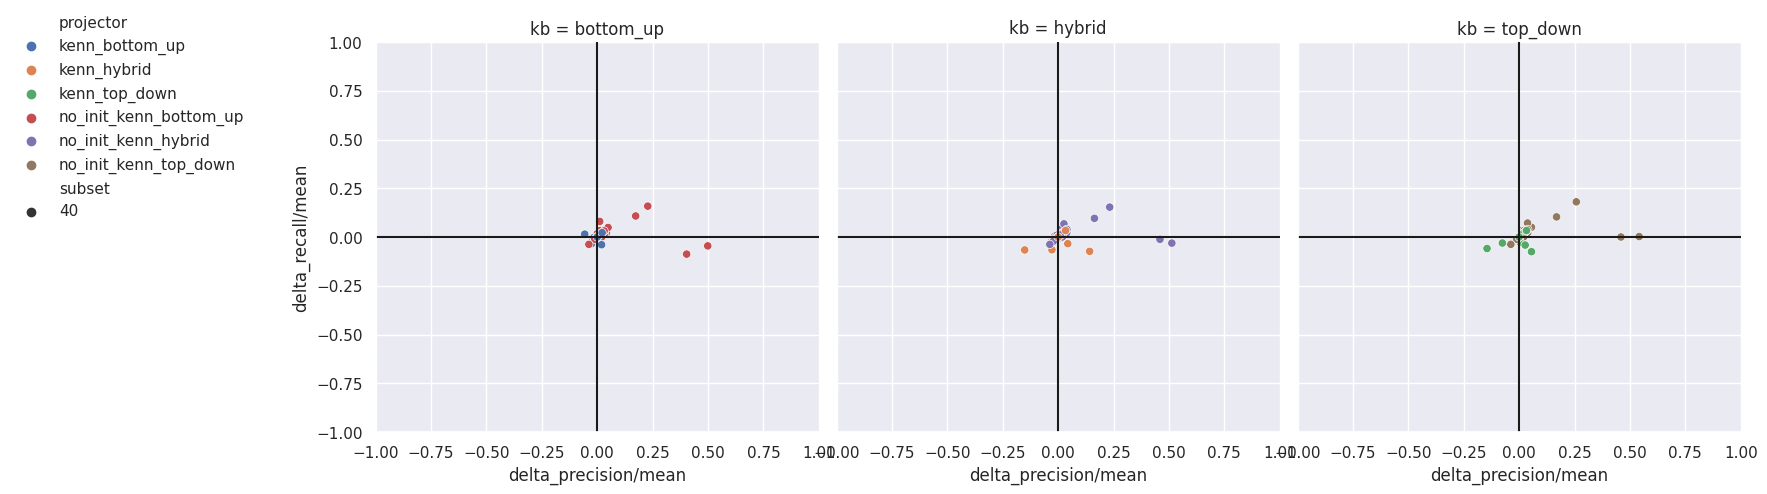

In [13]:
delta_df = compute_delta_df(df_metrics_macro_example)
delta_df['kb'] = delta_df['projector'].apply(lambda x : x.split('kenn_')[-1])
for subset in SUBSET:
       print('######### SUBSET', subset, '##########')
       fig = plot_df(filter_df(delta_df, {'subset': subset,
                                          'projector': [
                                                 'kenn_bottom_up', 'no_init_kenn_bottom_up',
                                                 'kenn_top_down', 'no_init_kenn_top_down',
                                                 'kenn_hybrid', 'no_init_kenn_hybrid',
                                                 ]}))

## Macro types

######### SUBSET 10 ##########


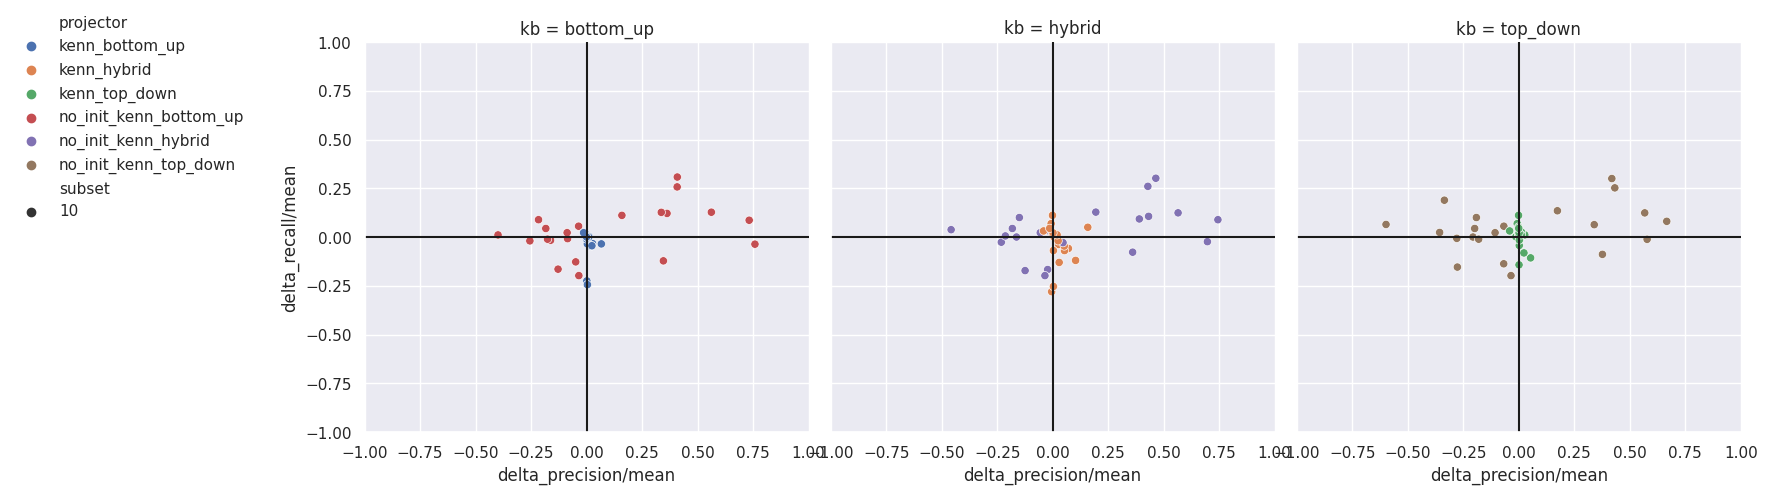

######### SUBSET 20 ##########


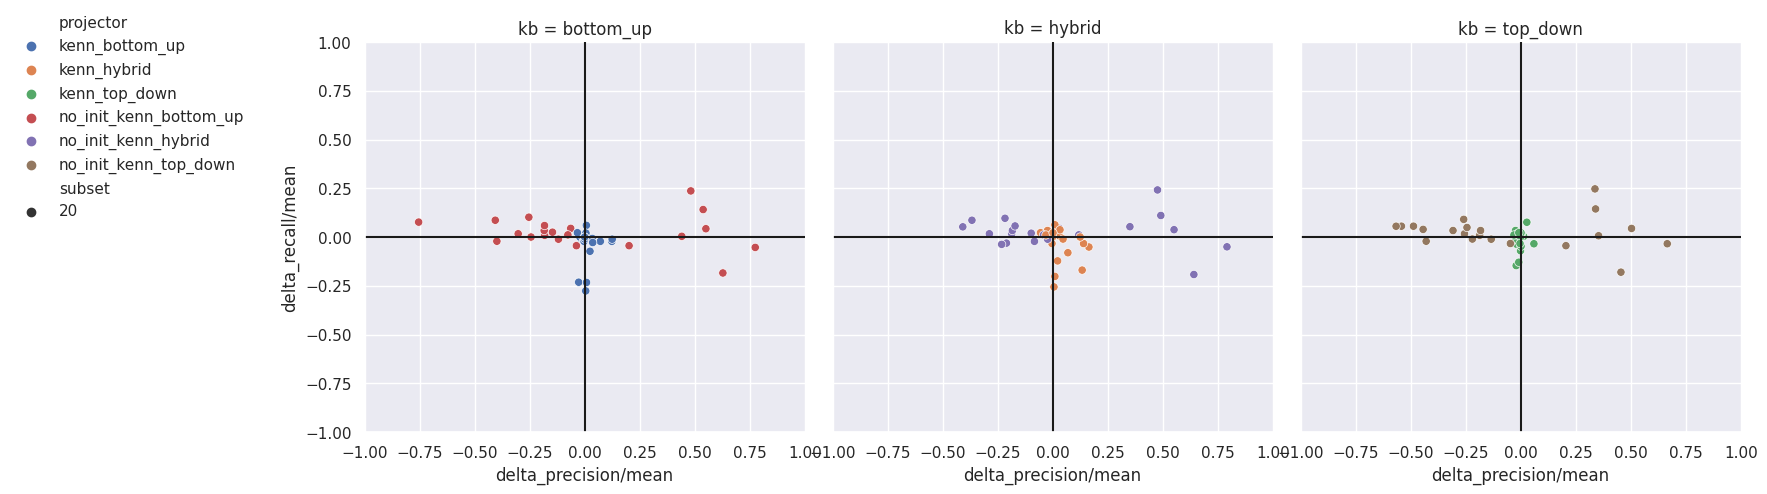

######### SUBSET 40 ##########


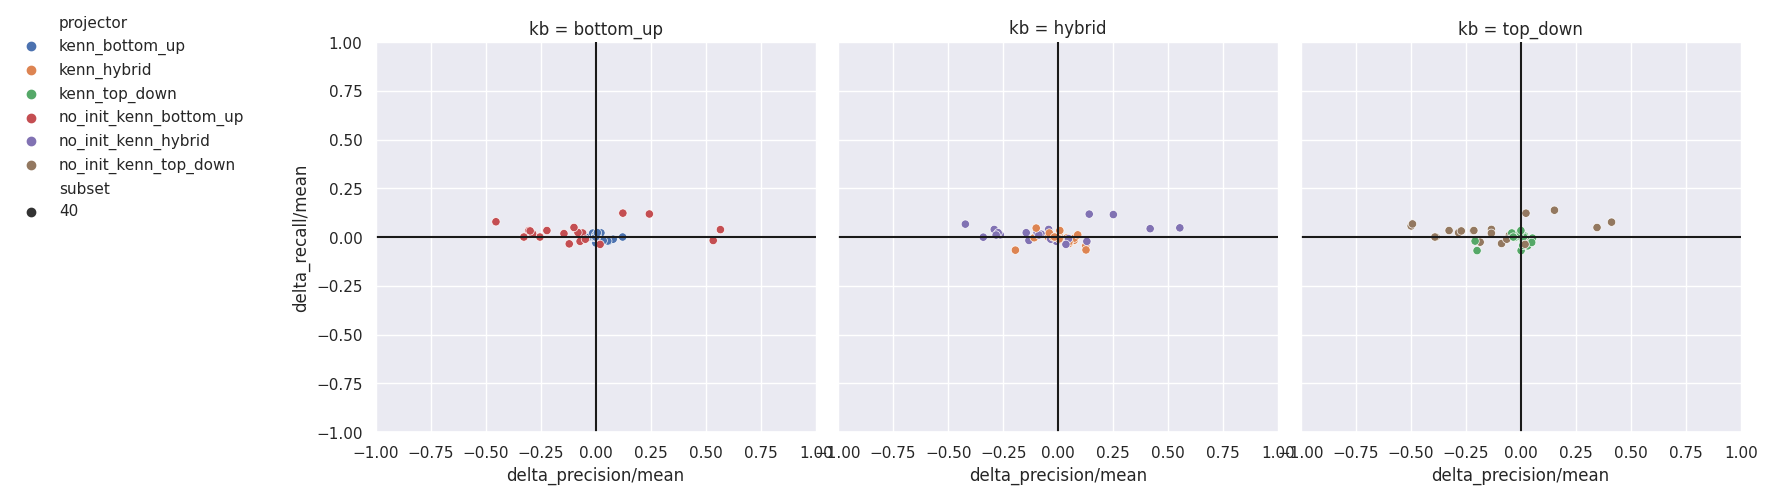

In [14]:
delta_df = compute_delta_df(df_metrics_macro_types)
delta_df['kb'] = delta_df['projector'].apply(lambda x : x.split('kenn_')[-1])
for subset in SUBSET:
       print('######### SUBSET', subset, '##########')
       fig = plot_df(filter_df(delta_df, {'subset': subset,
                                          'projector': ['kenn_bottom_up', 'no_init_kenn_bottom_up',
                                                 'kenn_top_down', 'no_init_kenn_top_down',
                                                 'kenn_hybrid', 'no_init_kenn_hybrid',
                                                 ]}))